# Test of reprojection
In this notebook we will test our reprojection method on 2 frames taken with the Dragonfly instrument. The goal of this notebook is to demonstrate that the results are equivalent and that we gain a speedup using our methodology.

In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import time
from reprojection.reproject import calculate_reprojection
from matplotlib import pyplot as plt
import cmcrameri.cm as cmc
from reproject import reproject_interp

We now read in the data. Please update this with your own data if you wish to test it locally.

In [2]:
light1 = './data/Atik1442426-0035_0032_light.fits'
light2 = './data/Atik1442428-0045_0032_light.fits'

light1_hdu = fits.open(light1)[0]
light2_hdu = fits.open(light2)[0]
light1_wcs = WCS(light1_hdu.header)

Let's go ahead and visualize these  two frames.

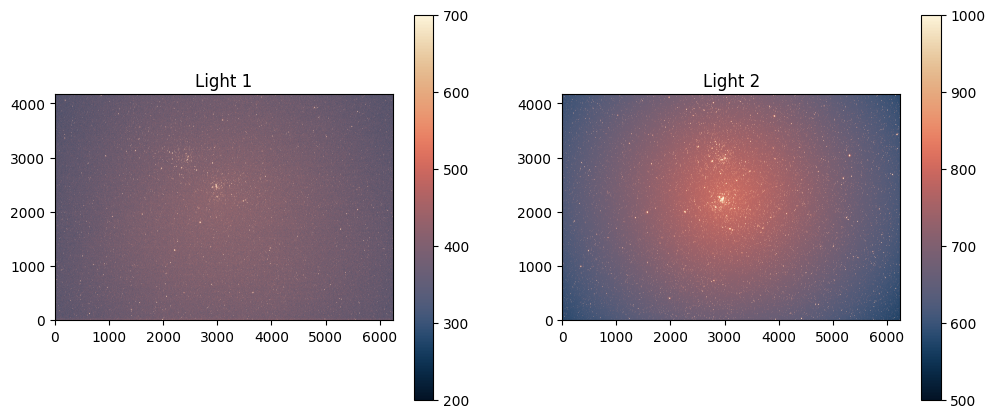

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

im = axs[0].imshow(light1_hdu.data, origin='lower', cmap=cmc.lipari, vmin=200, vmax=700)
axs[0].set_title(f"Light 1")
plt.colorbar(im, ax=axs[0], shrink=0.5)

im = axs[1].imshow(light2_hdu.data, origin='lower', cmap=cmc.lipari, vmin=500, vmax=1000)
axs[1].set_title(f"Light 2")
plt.colorbar(im, ax=axs[1], shrink=0.5)

plt.show()


Between these two frames there is some rotation (about 90 degrees) and slight translation.

## Reprojection
Now let's go ahead and do the reprojections using a cubic reprojection.


In [5]:
start = time.time()
reprojected_source_torch = calculate_reprojection(source_hdus=light2_hdu, target_wcs=light1_wcs,  shape_out=(light1_hdu.data.shape),interpolation_mode="bilinear")
torch_time = time.time()-start
print(f"total time: {torch_time}")

total time: 1.2427544593811035


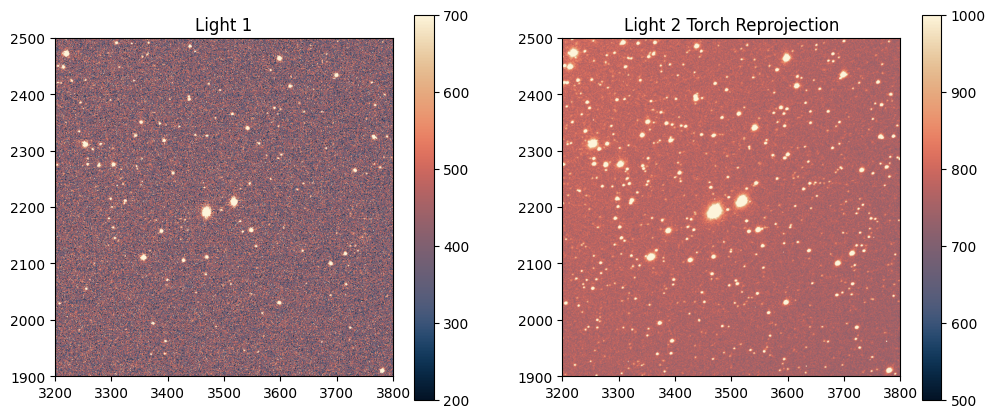

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

im = axs[0].imshow(light1_hdu.data, origin='lower', cmap=cmc.lipari, vmin=200, vmax=700)
axs[0].set_title(f"Light 1")
axs[0].set_xlim(3200, 3800)
axs[0].set_ylim(1900, 2500)
plt.colorbar(im, ax=axs[0], shrink=0.5)

im = axs[1].imshow(reprojected_source_torch, origin='lower', cmap=cmc.lipari, vmin=500, vmax=1000)
axs[1].set_title(f"Light 2 Torch Reprojection")
axs[1].set_xlim(3200, 3800)
axs[1].set_ylim(1900, 2500)
plt.colorbar(im, ax=axs[1], shrink=0.5)

plt.show()



|As we can see the results are extremely similar. The differences are due to how the normalization is handled in our implementation versus reproject_interp.

In [7]:
start = time.time()
reprojected_source_reproj = reproject_interp(light2_hdu, light1_hdu.header,order='bilinear')[0]
reproject_time = time.time()-start
print(f"total time: {reproject_time}")

total time: 42.001869916915894


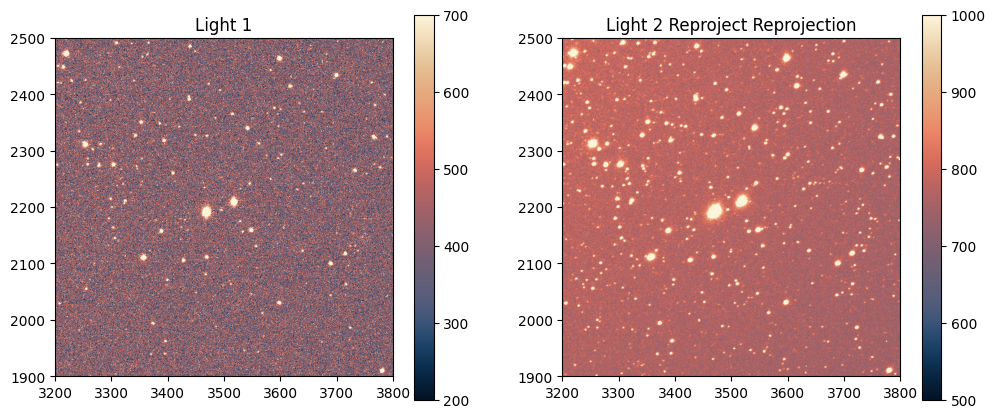

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 10))

im = axs[0].imshow(light1_hdu.data, origin='lower', cmap=cmc.lipari, vmin=200, vmax=700)
axs[0].set_title(f"Light 1")
axs[0].set_xlim(3200, 3800)
axs[0].set_ylim(1900, 2500)
plt.colorbar(im, ax=axs[0], shrink=0.5)

im = axs[1].imshow(reprojected_source_reproj, origin='lower', cmap=cmc.lipari, vmin=500, vmax=1000)
axs[1].set_title(f"Light 2 Reproject Reprojection")
axs[1].set_xlim(3200, 3800)
axs[1].set_ylim(1900, 2500)
plt.colorbar(im, ax=axs[1], shrink=0.5)

plt.show()


So we can see that the results look consistent accross the methods. Let's go ahead and double check that by plotting out the residuals.

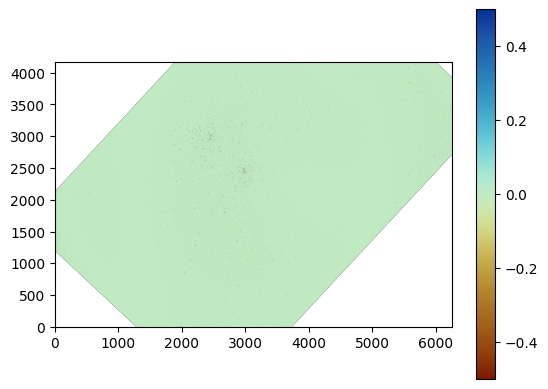

In [13]:
error = 100 * (reprojected_source_torch - reprojected_source_reproj)/reprojected_source_reproj
plt.imshow(error, origin='lower', cmap=cmc.roma, vmin=-0.5, vmax=0.5)
plt.colorbar()
plt.show()